In [1]:
import sys
sys.path.append("..")

In [2]:
import torch
from torch import nn
    
from general.model_utils import *
from general.data import *
from general.utils import *
from general.results_handler import *
from general.visualization import *

In [3]:
from C2D_Models import *
from C3D_Models import *
from ConvLSTM_AE.ConvLSTM_AE import *
from PatchWise.models_PatchWise import PatchWise_C2D
%matplotlib inline

In [9]:
class SoftMaxConvAttentionRNNWrapper(nn.Module):
    # Based on SoftMaxConvAttentionWrapper5
    # V5 -> Summation, normalization, scaling, Tensor Multiplication
    def __init__(self, channels, kernel_sizes = (3,5), projection = 64):
        super(SoftMaxConvAttentionRNNWrapper, self).__init__()
        self.channels = channels
        self.projection = projection
        self.kernel_sizes = kernel_sizes
        
        self.attention_conv = nn.Sequential(
            nn.Conv2d(self.channels, self.projection, self.kernel_sizes[0], 1, padding = self.kernel_sizes[0]//2),
            nn.Conv2d(self.projection, self.channels, self.kernel_sizes[1], 1, padding = self.kernel_sizes[1]//2),
            nn.BatchNorm2d(self.channels),
            nn.AvgPool2d(9, stride = 1, padding = 4)
        )
        
        self.ma_conv = TimeDistributed(moving_average_1d(window = 9))
        self.__name__ = "_SMCARnnW_P%s_C%s"%(self.projection, self.channels)
        
    def normalize(self, x, axis):
        x -= x.min(axis, keepdim = True)[0]
        x /= x.max(axis, keepdim = True)[0]
        return x
    
    def attention_forward(self, x):
        attention_activations = self.attention_conv(x)
        # Axis-wise sumamtion
        v = torch.mean(attention_activations, keepdim = True, axis = -2)
        h = torch.mean(attention_activations, keepdim = True, axis = -1)
        # Axis-wise Softmax
        vs = F.softmax(v, dim = -1)
        hs = F.softmax(h, dim = -2)
        # Axis-wise normalization
#         vs = self.normalize(vs, axis = -1)
#         hs = self.normalize(hs, axis = -2)
        # Axis-wise scaling
        vs = scale(vs, t_min = 3e-1)
        hs = scale(hs, t_min = 3e-1)
        # Applying moving average
        vs = self.ma_conv(vs)
        hs = self.ma_conv(hs.transpose(-1,-2)).transpose(-1,-2)
        # Axis-wise scaling
        vs = scale(vs, t_min = 3e-1)
        hs = scale(hs, t_min = 3e-1)
        # Tensor Multiplication
        x_a = torch.matmul(hs, vs)
        self.xam = x_a
        # Applying Hadamard product
        return torch.multiply(x, x_a)
        
    def forward(self, x):
        return self.attention_forward(x)

In [10]:
td_sca = TimeDistributed(SoftMaxConvAttentionRNNWrapper(3))

In [14]:
td_sca(torch.rand(32,3,8,128,128)).shape

RuntimeError: Given groups=1, weight of size [64, 3, 3, 3], expected input[32, 8, 128, 128] to have 3 channels, but got 8 channels instead

In [15]:
# Attention Recurrent Conv
class CRNN_AE_ATTN2(nn.Module):
    def __init__(
        self,
        image_size = 128,
        channels = 3,
        filter_count = [64,64,64,128],
        filter_sizes = [3,3,3,5],
        filter_strides = [2,2,2,2],
        n_rnn_layers = 2,
        disableDeConvRNN = True,
        useBias = False
    ):
        super(CRNN_AE_ATTN2, self).__init__()
        self.__name__ = "CRNN_AE_ATTN2_%d_%dx%d_L-%d_RL-%d_DisDeConv-%s-"%(image_size, most_common(filter_sizes), most_common(filter_sizes), len(filter_count), n_rnn_layers, "Y" if disableDeConvRNN else "N")
        self.channels = channels
        self.image_size = image_size
        self.filter_count = filter_count
        self.filter_sizes = filter_sizes
        self.filter_strides = filter_strides
        self.disableDeConvRNN = disableDeConvRNN
        
        self.n_layers = len(self.filter_count)
        self.n_rnn_layers = n_rnn_layers
        self.n_normal = self.n_layers - self.n_rnn_layers
        
        assert len(filter_count) == len(filter_sizes), "Number of filter sizes and count should be the same"
        assert len(filter_count) == len(filter_strides), "Number of filter strides and count should be the same"
        
        current_input_shape = self.image_size
        in_channels = self.channels
        
        self.encoder_layers = list()
        for idx, (n, k, s) in enumerate(zip(self.filter_count, self.filter_sizes, self.filter_strides)):
            if (self.n_layers - idx) > self.n_rnn_layers:
                insert = TimeDistributed(C2D_BN_A(in_channels, n, k, s))
            else:
                insert = ConvRNN_Cell(current_input_shape, in_channels, n, k, s, useBias=useBias)
            self.encoder_layers.append(insert)
            current_input_shape = getConvOutputShape(current_input_shape, k, s)
            in_channels = n
            
        self.embedding_shape = [1, n, current_input_shape, current_input_shape]
            
        self.decoder_layers = list()
        
        for idx, (n, k, s) in enumerate(zip(self.filter_count[::-1], self.filter_sizes[::-1], self.filter_strides[::-1])):
            oc_idx = len(self.filter_count) - (2 + idx)
            activation_type = "leaky_relu"
            if oc_idx > -1: out_channels = self.filter_count[oc_idx]
            else:
                out_channels = self.channels
                if k%2 !=0: k += 1
                activation_type = "sigmoid"
            if idx < self.n_rnn_layers and not self.disableDeConvRNN:
                insert = ConvTransposeRNN_Cell(current_input_shape, n, out_channels, k, s, useBias=useBias)
            else:
                insert = TimeDistributed(CT2D_BN_A(n, out_channels, k, s, activation_type = activation_type))
            self.decoder_layers.append(insert)
            current_input_shape = getConvTransposeOutputShape(current_input_shape, k, s)
        
        # For cuda use
        self.modules = nn.ModuleList(self.encoder_layers + self.decoder_layers)
        self.attention = TimeDistributed(SoftMaxConvAttentionRNNWrapper(3))
                                
    def forward(self, x):
        bs,c,ts,w,h = x.shape
        # bs,c,ts,w,h -> bs,ts,c,w,h -> attention -> bs,ts,c,w,h -> bs,c,ts,w,h
        x = self.attention(x.permute(0,2,1,3,4)).permute(0,2,1,3,4)
        preliminary_encodings = nn.Sequential(*self.encoder_layers[:(self.n_layers - self.n_rnn_layers)])(x.permute(0,2,1,3,4)) # bs,ts,c,w,h
        # preliminary_encodings -> bs,ts,c,w,h
        
        if self.n_rnn_layers != 0:
            states_list = [None] * 2 * self.n_rnn_layers
            current_input = preliminary_encodings
            rnn_outputs = list()
            rnn_layers = self.encoder_layers[self.n_normal:]
            if not self.disableDeConvRNN: rnn_layers += self.decoder_layers[:self.n_rnn_layers]
            for idx, layer in enumerate(rnn_layers):
                layer_outputs = list()
                states = states_list[idx]
                for t in range(ts):
                    y, h = layer(current_input[:,t,...], states)
                    layer_outputs.append(y)
                    states = h
                layer_output = torch.stack(layer_outputs, dim = 1) # b,ts,c,w,h
                rnn_outputs.append(layer_output)
                current_input = layer_output
                states_list[idx] = states
            encodings = rnn_outputs[self.n_rnn_layers - 1].transpose(1,2)
        else:
            layer_output = preliminary_encodings
            encodings = layer_output
        
        decode_index = self.n_rnn_layers
        if self.disableDeConvRNN: decode_index = 0
        reconstructions = nn.Sequential(*self.decoder_layers[decode_index:])(layer_output)
        reconstructions = reconstructions.transpose(1,2)
        return reconstructions, encodings

In [16]:
r, e = CRNN_AE_ATTN2()(torch.rand(32,3,8,16,16))

In [17]:
r.shape, e.shape

(torch.Size([32, 3, 8, 128, 128]), torch.Size([32, 128, 8, 6, 6]))

In [4]:
c2d = C2D_AE_COMBO(useInputAttention=True)

In [5]:
r,e = c2d(torch.rand(4,3,128,128))
print(r.shape, e.shape)

torch.Size([4, 3, 128, 128]) torch.Size([4, 96, 4, 4])


In [4]:
c2d = C2D_ACB(3,64,3,2)
c2d.channels = 3
c2d.__name__ = "ip_cov"
sw = SoftMaxConvAttentionWrapper5(c2d,layerWrapper=True)

In [5]:
a = sw(torch.rand(4,3,128,128))

In [6]:
a.shape

torch.Size([4, 64, 64, 64])

In [7]:
op = tensor_to_numpy(sw.xam[1].permute(1,2,0))

In [8]:
op.min(), op.max()

(0.09, 0.99990314)

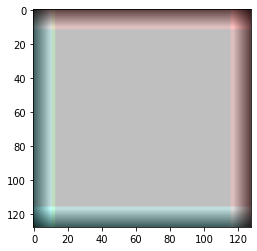

In [9]:
plt.imshow(op)

In [10]:
op.shape

(128, 128, 3)

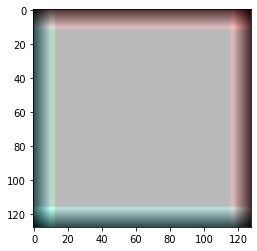

In [11]:
plt.imshow((op-op.min())/(op.max()-op.min()))

In [63]:
a = np.random.rand(50)

In [64]:
a = (a - a.min())/(a.max() - a.min())

In [65]:
soft_a = np.exp(a)/np.exp(a).sum()

In [66]:
scaled_a = scale(soft_a, t_min = 3e-1)

In [77]:
mv_a = tensor_to_numpy(mean_conv(torch.Tensor(scaled_a).view(1,1,-1))).squeeze()

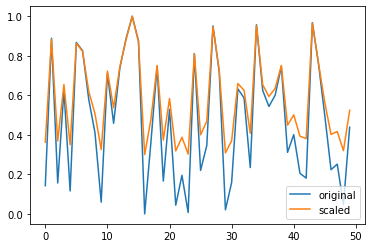

In [73]:
plt.plot(list(range(len(a))),a , label="original")
# plt.plot(list(range(len(a))), soft_a , label="softmax")
plt.plot(list(range(len(a))), scaled_a , label="scaled")
plt.legend()

In [80]:
mv_a

array([0.48238415, 0.5571718 , 0.6134442 , 0.6595047 , 0.6890522 ,
       0.7547291 , 0.7705782 , 0.75791365, 0.8045004 , 0.835876  ,
       0.88318485, 0.83202404, 0.8006286 , 0.8126253 , 0.8005216 ,
       0.8240341 , 0.78730464, 0.7737561 , 0.73366207, 0.72713214,
       0.67261744, 0.6360594 , 0.6948605 , 0.71769387, 0.67747897,
       0.6771655 , 0.6840658 , 0.71195006, 0.71375567, 0.772906  ,
       0.75872374, 0.776348  , 0.7914698 , 0.77367574, 0.7482583 ,
       0.76574796, 0.7678297 , 0.7424918 , 0.77336764, 0.8053463 ,
       0.76975894, 0.74690187, 0.73075825, 0.7021405 , 0.6815212 ,
       0.640713  , 0.5951692 , 0.5594441 , 0.52482176, 0.4371142 ],
      dtype=float32)

In [81]:
(mv_a - mv_a.min()) / (mv_a.max() - mv_a.min())

array([0.10148603, 0.26914483, 0.39529613, 0.49855444, 0.564794  ,
       0.7120282 , 0.7475587 , 0.71916735, 0.8236054 , 0.89394313,
       1.        , 0.88530785, 0.8149256 , 0.84181976, 0.81468576,
       0.867396  , 0.785056  , 0.7546829 , 0.6648002 , 0.65016145,
       0.5279505 , 0.44599482, 0.577815  , 0.62900275, 0.5388491 ,
       0.5381464 , 0.55361545, 0.6161263 , 0.6201741 , 0.75277716,
       0.7209834 , 0.7604934 , 0.7943935 , 0.7545028 , 0.697522  ,
       0.7367303 , 0.74139714, 0.68459463, 0.7538121 , 0.82550174,
       0.7457221 , 0.6944812 , 0.65829045, 0.5941353 , 0.5479109 ,
       0.4564272 , 0.35432723, 0.27423888, 0.19662255, 0.        ],
      dtype=float32)

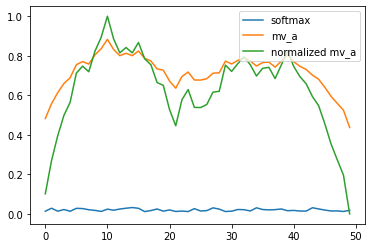

In [82]:
plt.plot(list(range(len(a))), soft_a , label="softmax")
plt.plot(list(range(len(a))), mv_a , label="mv_a")
plt.plot(list(range(len(a))), (mv_a - mv_a.min())/(mv_a.max() - mv_a.min()) , label="normalized mv_a")
plt.legend()

In [8]:
def moving_average_1d(window = 11):
    mean_conv = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=window, padding = window//2)
    kernel_weights = np.array([1.0]*window)/window
    mean_conv.weight.data = torch.FloatTensor(kernel_weights).view(1, 1, -1)
    return mean_conv    

In [9]:
mean_conv = moving_average_1d()

In [106]:
try: del c2d
except: pass
c2d = C2D_AE_COMBO(
    acb_layers=[False, False, False, False, False],
    res_layers=[False, False, False, False, False],
    sqzex_layers=[True] * 5,
    dropouts=[0.10, 0.20, 0.20, 0.20, 0.10],
    encoder_activation='relu',
    decoder_activation='leaky_relu',
    encoding_activation='tanh',
    stop_size=None,
    extra_id='',
    useInputAttention=False,
    useAAC_first=False,
    isDecoderReplica=True,
    addEndConv=True,
)

In [107]:
r, e = c2d(torch.rand(1,3,128,128))
print(r.shape, e.shape)
print(c2d.image_sizes)

torch.Size([1, 3, 128, 128]) torch.Size([1, 96, 4, 4])
[128, [63, 3, 2], [31, 3, 2], [15, 3, 2], [7, 3, 2], [4, 4, 1], [7, 4, 1], [15, 3, 2], [31, 3, 2], [63, 3, 2], [130, 6, 2], [128, 3, 1]]


In [108]:
c2d

C2D_AE_COMBO(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): SE_Block(
      (squeeze): AdaptiveAvgPool2d(output_size=1)
      (excitation): Sequential(
        (0): Linear(in_features=64, out_features=4, bias=False)
        (1): ReLU(inplace=True)
        (2): Linear(in_features=4, out_features=64, bias=False)
        (3): Sigmoid()
      )
    )
    (2): Dropout2d(p=0.1, inplace=False)
    (3): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (4): SE_Block(
      (squeeze): AdaptiveAvgPool2d(output_size=1)
      (excitation): Sequential(
        (0): Linear(in_features=64, out_features=4, bias=False)
        (1): ReLU(inplace=True)
        (2): Linear(in_features=